In [1]:
import sys
sys.path.insert(0,'../src')

#@title Run to install MuJoCo and `dm_control`
import distutils.util
import subprocess

# print('Installing dm_control...')
# !pip install -q dm_control==1.0.8

# Use egl locally
%env MUJOCO_GL=egl
# Use osmesa on DSMLP
# %env MUJOCO_GL=osmesa
%env PYOPENGL_PLATFORM=
%env PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

print('Checking that the dm_control installation succeeded...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
    del pixels, suite


#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# # Soccer
# from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import Adam
# from torch.utils.tensorboard import SummaryWriter

# try out the wrappers
from acme import wrappers
from dm_control import suite
from acme import wrappers
from model import *
from utils import *
# Soft-Actor-Critic Model
from sac import *
from replay_memory import *
import argparse
import datetime
import itertools
import os
import random
import math
import pickle

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)


######  Environment wrappers  ####
from dm_env import specs




from IPython.display import display, HTML

#@title Loading and simulating a `suite` task{vertical-output: true}

# Load the environment
# random_state = np.random.RandomState(42)
# env = suite.load('hopper', 'stand', task_kwargs={'random': random_state})


env: MUJOCO_GL=egl
env: PYOPENGL_PLATFORM=
env: PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
Checking that the dm_control installation succeeded...


/usr/lib/python3/dist-packages/ipywidgets/widgets/widget_link.py:19: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`) Passing types is deprecated in traitlets 4.1.
  super(WidgetTraitTuple, self).__init__(Instance(Widget), Unicode, **kwargs)
/usr/lib/python3/dist-packages/ipywidgets/widgets/widget_link.py:19: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`) Passing types is deprecated in traitlets 4.1.
  super(WidgetTraitTuple, self).__init__(Instance(Widget), Unicode, **kwargs)
/home/scott/.local/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [2]:
# load the environment
env = suite.load(domain_name="walker", task_name="walk")
# add wrappers onto the environment
env = NormilizeActionSpecWrapper(env)
env = MujocoActionNormalizer(environment=env, rescale='clip')
env = wrappers.SinglePrecisionWrapper(env)


class Args:
    env_name = 'whatever'
    policy = 'Gaussian'
    eval = True
    gamma = 0.99
    tau = 0.005
    lr = 0.0003
    alpha = 0.2
    automatic_entropy_tuning = True
    seed = 42
    batch_size = 512
    num_steps = 1000000
    hidden_size = 1024
    updates_per_step = 1
    start_steps = 10000
    target_update_interval = 1
    replay_size = 1000000
    # use the cuda to speedup
    cuda = True


args = Args()

# get the dimensionality of the observation_spec after flattening
flat_obs = tree.flatten(env.observation_spec())
# combine all the shapes
# obs_dim = sum([item.shape[0] for item in flat_obs])
obs_dim = 0
for i in flat_obs:
    try:
        obs_dim += i.shape[0]
    except IndexError:
        obs_dim += 1

# setup agent, using Soft-Actor-Critic Model
agent = SAC(obs_dim, env.action_spec(), args)
# load checkpoint - UPLOAD YOUR FILE HERE!
model_path = '../data/models/sac_checkpoint_walker_walk_batch512_hidden1024_1123_500'
agent.load_checkpoint(model_path, evaluate=True)

# pull out model
model = agent.policy
# setup hook dict
hook_dict = init_hook_dict(model)
# add hooks
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        module.register_forward_hook(recordtodict_hook(name=name, hook_dict=hook_dict))

Loading models from ../data/models/sac_checkpoint_walker_walk_batch512_hidden1024_1123_500


In [3]:
WALKER_GEOM_NAMES = ['floor', 'torso', 'right_thigh', 'right_leg', 'right_foot', 'left_thigh', 'left_leg', 'left_foot']
geom_names_to_idx = {geom_name: idx for idx, geom_name in enumerate(WALKER_GEOM_NAMES)}

In [5]:
# for recording kinematics
total_kinematic_dict = {
    'geom_positions': []
}

frames = []
ticks = []
observations = []
rewards = []
time_step = env.reset()
while not time_step.last():  # or env.get_termination()
    # get the state
    state = get_flat_obs(time_step)
    # sample an action
    action = agent.select_action(state)
    time_step = env.step(action)
        
    camera0 = env.physics.render(camera_id=0, height=288, width=432)
    camera1 = env.physics.render(camera_id=1, height=288, width=432)
    frames.append(np.hstack((camera0, camera1)))
    # record kinematics
    kinematic_dict = get_geoms(env.physics, WALKER_GEOM_NAMES)
    total_kinematic_dict['geom_positions'].append(kinematic_dict['geom_positions'])
    # record reward
    time_step_reward = time_step.reward
    rewards.append(time_step_reward)
save_video(frames, video_name="sac_test_video.mp4")
print("Rendering Complete!")

Rendering Complete!


In [5]:
# # run a few episodes just to collect activations
# num_episodes_to_run = 42

# # for recording kinematics
# total_kinematic_dict = {
#     'geom_positions': []
# }

# rewards = []
# states = []
# actions = []
# for i in range(num_episodes_to_run):
#     time_step = env.reset()
#     episode_reward = 0
#     while not time_step.last():  # or env.get_termination()
#         # get the state
#         state = get_flat_obs(time_step)
#         # sample an action
#         action = agent.select_action(state)
#         time_step = env.step(action)

#         # record kinematics
#         kinematic_dict = get_geoms(env.physics, WALKER_GEOM_NAMES)
#         total_kinematic_dict['geom_positions'].append(kinematic_dict['geom_positions'])
#         # record reward
#         time_step_reward = time_step.reward
#         rewards.append(time_step_reward)
#         episode_reward += time_step_reward
        
#         #record states and actions
#         states.append(state)
#         actions.append(action)
#     if i % 10 == 0:
#         print('Episode: {} Reward: {}'.format(i+1, episode_reward))

In [6]:
total_kinematic_dict['geom_positions'] = np.stack(total_kinematic_dict['geom_positions'],axis=0)

In [7]:
total_kinematic_dict['geom_positions'].shape

(1000, 8, 3)

In [8]:
def plot_tsne(trans, name):
    os.makedirs("tsne/", exist_ok=True)
    plt.scatter(trans[:, 0], trans[:, 1], s=1)
    plt.title(name)
    #plt.savefig(f"tsne/{name}.png", dpi=200)
#     plt.savefig(f"tsne/{name}.png", dpi=72)

In [9]:
from sklearn.manifold import TSNE

In [10]:
#X = total_kinematic_dict["geom_positions"][:,:,2]
#tsne = TSNE(init="pca",learning_rate="auto", n_jobs=-1)
#trans = tsne.fit_transform(X)
#plot_tsne(trans, "Perplexity=30 Z geom_positions")

In [11]:
#X = total_kinematic_dict["geom_positions"][:,:,2]
#tsne = TSNE(init="pca",learning_rate="auto", perplexity=50, n_jobs=-1)
#trans = tsne.fit_transform(X)
#plot_tsne(trans, "Perplexity=50 Z geom_positions")

In [12]:
len(total_kinematic_dict["geom_positions"][:,:,2])

1000

In [14]:
%matplotlib inline

/home/scott/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


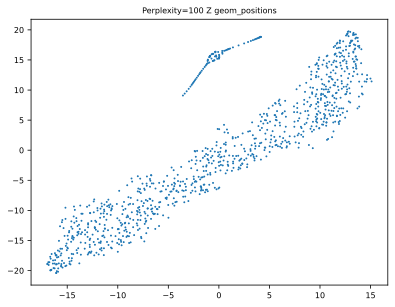

In [15]:
X = total_kinematic_dict["geom_positions"][:,:,2]
tsne = TSNE(init="pca",learning_rate="auto", perplexity=100, n_jobs=-1, random_state=123)
trans = tsne.fit_transform(X)
plot_tsne(trans, "Perplexity=100 Z geom_positions")


In [16]:
len(trans)

1000

In [17]:
len(trans[:, 0])

1000

In [29]:
np.save("points.npy", trans)

In [30]:
X = np.load("points.npy")

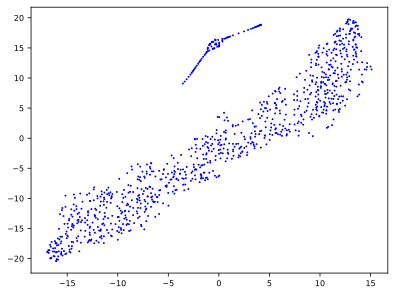

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#x = trans[:, 0]
#y = trans[:, 1]
x = X[:, 0]
y = X[:, 1]

# Create a scatter plot
#fig, ax = plt.subplots(figsize=(400, 400), dpi=72)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c='blue', s=1)

# Define the update function for the animation
def update(frame):
    # Select the data up to the current frame
    xdata = x[:frame]
    ydata = y[:frame]

    # Set the color of old points to blue and new points to red
    #colors = np.where(np.arange(n) < frame, 'blue', 'red')
    scatter.set_offsets(np.c_[xdata, ydata])
    #scatter.set_color(colors)

    return scatter,

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=len(x), blit=True)
# converting to an html5 video
writergif = animation.PillowWriter(fps=30)
#writergif = animation.FFMpegWriter(fps=30)
ani.save("test_video.gif", writer=writergif)

In [22]:
from PIL import Image
im = Image.open('sac_test_video.gif')
print("Number of frames: "+str(im.n_frames))
im.close()

Number of frames: 1000


In [23]:
im = Image.open('test_video.gif')
print("Number of frames: "+str(im.n_frames))
im.close()

Number of frames: 122


In [32]:
import imageio
import numpy as np
import cv2

#Create reader object for the gif
gif1 = imageio.get_reader('sac_test_video.gif')
gif2 = imageio.get_reader('test_video.gif')

#If they don't have the same number of frame take the shorter
number_of_frames = min(gif1.get_length(), gif2.get_length()) 

#Create writer object
new_gif = imageio.get_writer('output.gif', fps=30)

for frame_number in range(number_of_frames):
    img1 = np.array(gif1.get_next_data())
    img2 = np.array(gif2.get_next_data())
    #print(img1.shape)
    #print(img2.shape)
    new_image = np.hstack((img1, img2))
    new_gif.append_data(new_image)

gif1.close()
gif2.close()    
new_gif.close()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [21]:
#when the right foot reaches 0 (or below some threshold) again, we know that a full gait cycle has been completed. - unreliable
#total_kinematic_dict["geom_positions"][:,:,2][:, 4]

In [22]:
#when the right foot reaches 0 again, we know that a full gait cycle has been completed - unreliable
#np.where(total_kinematic_dict["geom_positions"][:,:,2][:, 8])

In [24]:
#manually inspect frames when the walker has "perfected" its stride
for i in range(500, 610):
    im = Image.open("sac_test_video.gif")
    im.seek(i)
    im.save("./frames/frame{}.png".format(i))
    im.close()

FileNotFoundError: [Errno 2] No such file or directory: './frames/frame500.png'

In [36]:
import pickle as pkl
with open('color_scheme.pkl', 'rb') as file:
    XL = pkl.load(file)

In [37]:
colors = ['purple', 'green', 'red', 'orange', 'grey', 'teal', 'gold', 'blue']

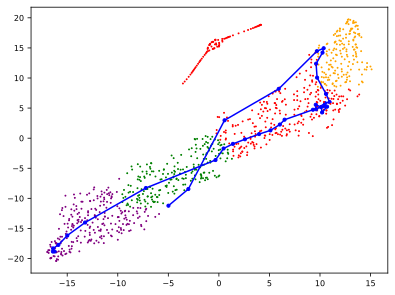

In [38]:
#x = trans[:, 0]
#y = trans[:, 1]
x = X[:, 0]
y = X[:, 1]
gait_cycle_start_frame = 517
gait_cycle_end_frame_plus_one = 551
gait_cycle_points_x, gait_cycle_points_y = X[:, 0][gait_cycle_start_frame:gait_cycle_end_frame_plus_one], X[:, 1][gait_cycle_start_frame:gait_cycle_end_frame_plus_one]
#color = ['blue' if i in list(range(gait_cycle_start_frame, gait_cycle_end_frame_plus_one)) else XL[i] for i in range(1000)]
color = [colors[7] if i in list(range(gait_cycle_start_frame, gait_cycle_end_frame_plus_one)) else colors[XL[i] - 1] for i in range(1000)]
size = [10 if i in list(range(gait_cycle_start_frame, gait_cycle_end_frame_plus_one)) else 1 for i in range(1000)]
plt.scatter(x, y, c=color, s=size)
plt.plot(gait_cycle_points_x, gait_cycle_points_y, c='blue')
plt.savefig("gait_cycle_tsne.png", dpi = 300)
plt.show()

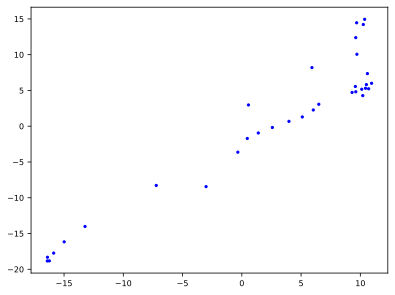

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#x = trans[:, 0]
#y = trans[:, 1]

x = trans[:, 0][gait_cycle_start_frame:gait_cycle_end_frame_plus_one]
y = trans[:, 1][gait_cycle_start_frame:gait_cycle_end_frame_plus_one]
#gait_cycle_points_x, gait_cycle_points_y = trans[:, 0][506:544], trans[:, 1][506:544]
#color = ['blue' if i in list(range(506, 544)) else 'grey' for i in range(1000)]
#size = [10 if i in list(range(506, 544)) else 1 for i in range(1000)]

# Create a scatter plot
#fig, ax = plt.subplots(figsize=(400, 400), dpi=72)
fig, ax = plt.subplots()
#scatter = ax.scatter(x, y, c=color, s=size)
scatter = ax.scatter(x, y, c='blue', s=5)
#line_plot = ax.plot(gait_cycle_points_x, gait_cycle_points_y, c='blue')

# Define the update function for the animation
def update(frame):
    # Select the data up to the current frame
    xdata = x[:frame]
    ydata = y[:frame]
    #if(frame >= 506 and frame <= 544):
    #    xdata_gait = gait_cycle_points_x[:frame]
    #    ydata_gait = gait_cycle_points_y[:frame]
    #    line_plot.set_offsets(np.c_[xdata_gait, ydata_gait])

    # Set the color of old points to blue and new points to red
    #colors = np.where(np.arange(n) < frame, 'blue', 'red')
    scatter.set_offsets(np.c_[xdata, ydata])
    #scatter.set_color(colors)

    return scatter,

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=len(x), blit=True)
# converting to an html5 video
writergif = animation.PillowWriter(fps=1)
#writergif = animation.FFMpegWriter(fps=30)
ani.save("gait_cycle_test.gif", writer=writergif)

In [24]:
#506-543 is one full gait cycle

In [ ]:
# #see where frame looks the exact same to detect end of gait cycle - unreliable
# from PIL import Image
# gif1 = imageio.get_reader('sac_test_video.gif')
# set_of_frames = set()
# for frame in range(number_of_frames):
#     img1 = np.array(gif1.get_next_data())
#     if(img1 not in set_of_frames):
#         set_of_frames.add(img1)
#     else:
        
    
        
# repeat_frame_freq_gait_cycle = 


# gif1.close()

In [19]:
# load the environment
env = suite.load(domain_name="walker", task_name="walk")
# add wrappers onto the environment
env = NormilizeActionSpecWrapper(env)
env = MujocoActionNormalizer(environment=env, rescale='clip')
env = wrappers.SinglePrecisionWrapper(env)
#from BCNetwork import BCNetwork
sys.path.insert(0,'../')
from src.sac import GaussianPolicy
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
flat_obs = tree.flatten(env.observation_spec())
obs_dim = 0
for i in flat_obs:
    try:
        obs_dim += i.shape[0]
    except IndexError:
        obs_dim += 1
network = GaussianPolicy(obs_dim, env.action_spec().shape[0], hidden_dim=1024).to(device)
#network = BCNetwork(24, 6, 1024).to(device)
#network.load_state_dict(
#    torch.load("../data/bc_stochastic_model_walker/bc_walker_nonoise_mse_entropy.pt")
#)
network.load_state_dict(
    torch.load("../data/bc_stochastic_model_walker/bc_walker_actnoise080_mse_kl_entropy.pt")
)

<All keys matched successfully>

In [20]:
WALKER_GEOM_NAMES = ['floor', 'torso', 'right_thigh', 'right_leg', 'right_foot', 'left_thigh', 'left_leg', 'left_foot']
geom_names_to_idx = {geom_name: idx for idx, geom_name in enumerate(WALKER_GEOM_NAMES)}

In [21]:
# for recording kinematics
total_bc_kinematic_dict = {
    'geom_positions': []
}

rewards = []
observations = []
frames = []
spec = env.action_spec()
time_step = env.reset()
while not time_step.last():
    flat_obs = tree.flatten(time_step.observation)
    flat_obs[0] = flat_obs[0].reshape(-1, 1)[0]
    state = np.concatenate(flat_obs)
    # add batch dimension
    state = np.expand_dims(state, axis=0)
    # sample an action
    tensor_state = torch.tensor(state, dtype=torch.float32)
    _, _, action = network.sample(tensor_state)
    action = action.detach().cpu().numpy()
    time_step = env.step(action)
    
    camera0 = env.physics.render(camera_id=0, height=288, width=432)
    camera1 = env.physics.render(camera_id=1, height=288, width=432)
    frames.append(np.hstack((camera0, camera1)))
    
    kinematic_dict = get_geoms(env.physics, WALKER_GEOM_NAMES)
    total_bc_kinematic_dict['geom_positions'].append(kinematic_dict['geom_positions'])
    time_step_reward = time_step.reward
    rewards.append(time_step_reward)
    observations.append(copy.deepcopy(time_step.observation))

save_video(frames, video_name="bc_test_video.gif")
print("Rendering Complete!")

Rendering Complete!


In [22]:
total_bc_kinematic_dict['geom_positions'] = np.stack(total_bc_kinematic_dict['geom_positions'],axis=0)

In [23]:
total_bc_kinematic_dict['geom_positions'].shape

(1000, 8, 3)

In [24]:
def plot_tsne(trans, name):
    os.makedirs("tsne/", exist_ok=True)
    plt.scatter(trans[:, 0], trans[:, 1], s=1)
    plt.title(name)
    #plt.savefig(f"tsne/{name}.png", dpi=200)
    plt.savefig(f"tsne/{name}.png", dpi=72)

In [25]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


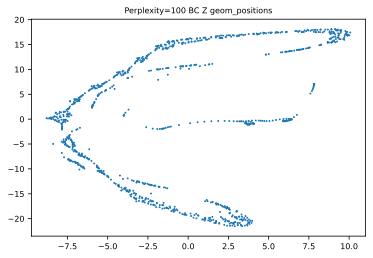

In [27]:
X = total_bc_kinematic_dict["geom_positions"][:,:,2]
tsne = TSNE(init="pca",learning_rate="auto", perplexity=100, n_jobs=-1)
trans = tsne.fit_transform(X)
plot_tsne(trans, "Perplexity=100 BC Z geom_positions")

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


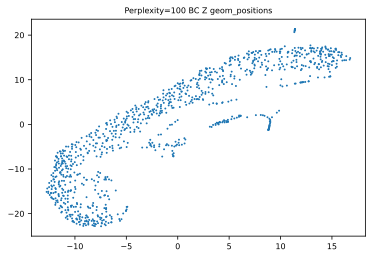

In [34]:
X = total_bc_kinematic_dict["geom_positions"][:,:,2]
tsne = TSNE(init="pca",learning_rate="auto", perplexity=100, n_jobs=-1)
trans = tsne.fit_transform(X)
plot_tsne(trans, "Perplexity=100 BC Z geom_positions")

In [35]:
np.save("points_bc.npy", trans)

In [28]:
np.save("points_bc_noise.npy", trans)

In [29]:
BC_X = np.load("points_bc.npy")
BC_X_noise = np.load("points_bc_noise.npy")

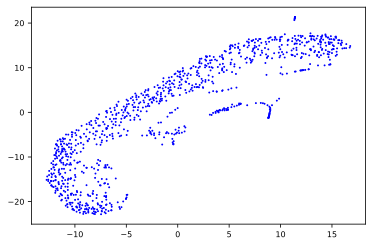

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
x = BC_X[:, 0]
y = BC_X[:, 1]

# Create a scatter plot
#fig, ax = plt.subplots(figsize=(400, 400), dpi=72)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c='blue', s=1)

# Define the update function for the animation
def update(frame):
    # Select the data up to the current frame
    xdata = x[:frame]
    ydata = y[:frame]

    # Set the color of old points to blue and new points to red
    #colors = np.where(np.arange(n) < frame, 'blue', 'red')
    scatter.set_offsets(np.c_[xdata, ydata])
    #scatter.set_color(colors)

    return scatter,

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=len(x), blit=True)
# converting to an html5 video
writergif = animation.PillowWriter(fps=30)
#writergif = animation.FFMpegWriter(fps=30)
ani.save("test_bc_video.gif", writer=writergif)

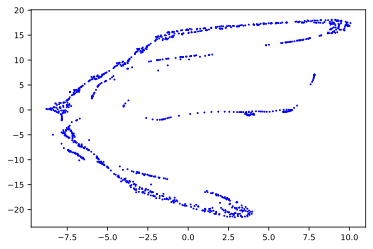

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
x = BC_X_noise[:, 0]
y = BC_X_noise[:, 1]

# Create a scatter plot
#fig, ax = plt.subplots(figsize=(400, 400), dpi=72)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c='blue', s=1)

# Define the update function for the animation
def update(frame):
    # Select the data up to the current frame
    xdata = x[:frame]
    ydata = y[:frame]

    # Set the color of old points to blue and new points to red
    #colors = np.where(np.arange(n) < frame, 'blue', 'red')
    scatter.set_offsets(np.c_[xdata, ydata])
    #scatter.set_color(colors)

    return scatter,

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=len(x), blit=True)
# converting to an html5 video
writergif = animation.PillowWriter(fps=30)
#writergif = animation.FFMpegWriter(fps=30)
ani.save("test_bc_noise_video.gif", writer=writergif)

In [34]:
import imageio
import numpy as np
import cv2

#Create reader object for the gif
gif1 = imageio.get_reader('bc_test_video.gif')
gif2 = imageio.get_reader('test_bc_video.gif')

#If they don't have the same number of frame take the shorter
number_of_frames = min(gif1.get_length(), gif2.get_length()) 

#Create writer object
new_gif = imageio.get_writer('output_bc.gif', fps=30)

for frame_number in range(number_of_frames):
    img1 = np.array(gif1.get_next_data())
    img2 = np.array(gif2.get_next_data())
    #print(img1.shape)
    #print(img2.shape)
    new_image = np.hstack((img1, img2))
    new_gif.append_data(new_image)

gif1.close()
gif2.close()    
new_gif.close()

In [35]:
import imageio
import numpy as np
import cv2

#Create reader object for the gif
gif1 = imageio.get_reader('bc_noise_test_video.gif')
gif2 = imageio.get_reader('test_bc_noise_video.gif')

#If they don't have the same number of frame take the shorter
number_of_frames = min(gif1.get_length(), gif2.get_length()) 

#Create writer object
new_gif = imageio.get_writer('output_bc_noise.gif', fps=30)

for frame_number in range(number_of_frames):
    img1 = np.array(gif1.get_next_data())
    img2 = np.array(gif2.get_next_data())
    #print(img1.shape)
    #print(img2.shape)
    new_image = np.hstack((img1, img2))
    new_gif.append_data(new_image)

gif1.close()
gif2.close()    
new_gif.close()

In [39]:
for i in range(500, 610):
    im = Image.open("bc_test_video.gif")
    im.seek(i)
    im.save("./frames_bc/frame{}.png".format(i))
    im.close()

In [36]:
for i in range(500, 610):
    im = Image.open("bc_noise_test_video.gif")
    im.seek(i)
    im.save("./frames_bc_noise/frame{}.png".format(i))
    im.close()

In [ ]:
#548-579 is a gait cycle

In [49]:
import pickle as pkl
with open('color_scheme_noise.pkl', 'rb') as file:
    XL = pkl.load(file)

In [50]:
set(XL)

{1, 2, 3, 5, 6}

In [54]:
colors = ['purple', 'green', 'teal', 'orange', 'grey', 'red', 'gold', 'blue']

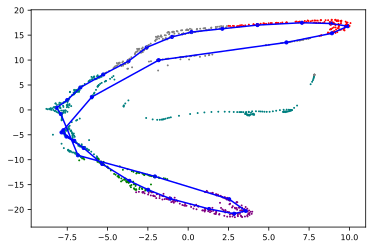

In [55]:
x = BC_X_noise[:, 0]
y = BC_X_noise[:, 1]
gait_cycle_start_frame = 548
gait_cycle_end_frame_plus_one = 581
gait_cycle_points_x, gait_cycle_points_y = BC_X_noise[:, 0][gait_cycle_start_frame:gait_cycle_end_frame_plus_one], BC_X_noise[:, 1][gait_cycle_start_frame:gait_cycle_end_frame_plus_one]
color = [colors[7] if i in list(range(gait_cycle_start_frame, gait_cycle_end_frame_plus_one)) else colors[XL[i] - 1] for i in range(1000)]
size = [10 if i in list(range(gait_cycle_start_frame, gait_cycle_end_frame_plus_one)) else 1 for i in range(1000)]
plt.scatter(x, y, c=color, s=size)
plt.plot(gait_cycle_points_x, gait_cycle_points_y, c='blue')
plt.savefig("gait_cycle_tsne_bc_noise.png", dpi = 300)
plt.show()

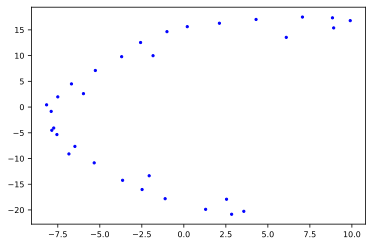

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#x = trans[:, 0]
#y = trans[:, 1]

x = BC_X_noise[:, 0][gait_cycle_start_frame:gait_cycle_end_frame_plus_one]
y = BC_X_noise[:, 1][gait_cycle_start_frame:gait_cycle_end_frame_plus_one]
#gait_cycle_points_x, gait_cycle_points_y = trans[:, 0][506:544], trans[:, 1][506:544]
#color = ['blue' if i in list(range(506, 544)) else 'grey' for i in range(1000)]
#size = [10 if i in list(range(506, 544)) else 1 for i in range(1000)]

# Create a scatter plot
#fig, ax = plt.subplots(figsize=(400, 400), dpi=72)
fig, ax = plt.subplots()
#scatter = ax.scatter(x, y, c=color, s=size)
scatter = ax.scatter(x, y, c='blue', s=5)
#line_plot = ax.plot(gait_cycle_points_x, gait_cycle_points_y, c='blue')

# Define the update function for the animation
def update(frame):
    # Select the data up to the current frame
    xdata = x[:frame]
    ydata = y[:frame]
    #if(frame >= 506 and frame <= 544):
    #    xdata_gait = gait_cycle_points_x[:frame]
    #    ydata_gait = gait_cycle_points_y[:frame]
    #    line_plot.set_offsets(np.c_[xdata_gait, ydata_gait])

    # Set the color of old points to blue and new points to red
    #colors = np.where(np.arange(n) < frame, 'blue', 'red')
    scatter.set_offsets(np.c_[xdata, ydata])
    #scatter.set_color(colors)

    return scatter,

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=len(x), blit=True)
# converting to an html5 video
writergif = animation.PillowWriter(fps=5)
#writergif = animation.FFMpegWriter(fps=30)
ani.save("gait_cycle_test_bc_noise.gif", writer=writergif)